In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-nov-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2022/train_labels.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.7301891713.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.6750726968.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.7194704070.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.7107007521.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.6952032365.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.7311830751.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.6736005999.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.7205109360.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.7298116981.csv
/kaggle/input/tabular-playground-series-nov-2022/submission_files/0.6737624943.csv
/kaggle/input/tabular-playground-

In [2]:
# Imports - basic
import os

# Imports - sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, log_loss 
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Imports - LightGBM
import lightgbm
from lightgbm import LGBMClassifier

In [3]:
# Import submission sample
subsample = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2022/sample_submission.csv', index_col = 'id')

# Get the indices of the submission samples
sub_idx = subsample.index

# Import labels
labels = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2022/train_labels.csv', index_col='id')

# Get the indices of the labels
label_idx = labels.index

In [4]:
# Get the submission file path info - sort to make it easier
sub_file_path = '/kaggle/input/tabular-playground-series-nov-2022/submission_files'

sub_files = sorted(os.listdir('/kaggle/input/tabular-playground-series-nov-2022/submission_files'))

# Count of files
print(f"There are {len(sub_files)} for the analysis.")

There are 5000 for the analysis.


In [5]:
# Set a limit for training files
# 70% training, 30% test
train_file_count = int(5000*0.70) #3500
test_file_count = int(5000 - train_file_count) #1500

### Build the Training Set

Each file in the submission files folder has an index and a prediction value. It is easier to feed them into a list and convert that list into an array, than to concatenate multiple dataframes along an axis.

In [6]:
# List of training data
train = []

# Iterate
for i in range(train_file_count):
    train.append(pd.read_csv(sub_file_path + '/' + sub_files[i], index_col='id')['pred'].values)

In [7]:
# Convert list to a usable array format
train_array = np.stack(train).T

# Check
train_array.shape

(40000, 3500)

# Logistic Regression

In [8]:
# Initialize LogisticRegression object
# L1 penalty, ridge regression, shrinks coefficients of variables with minor contributions to almost zero, but keeps all variables
# Liblinear because of one-vs-other
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=1)

In [9]:
# Fit to training data
logreg_model = logreg.fit(train_array[label_idx], labels['label'].values)

In [10]:
# Get the predictions
logreg_preds = logreg.predict_proba(train_array)[:,-1]

In [11]:
# Log-loss scoring
logreg_score = log_loss(labels, logreg_preds[label_idx])

# View
print(f"The score for the logistic regression model is {logreg_score}.")

The score for the logistic regression model is 0.49421591238741713.


Based on the log-loss score, this model performs at near-chance when predicting against the training set.

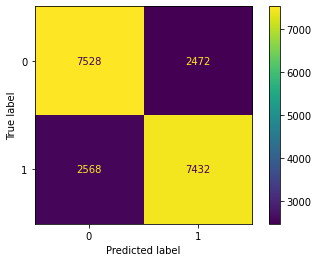

In [12]:
# Adjust logreg_preds to view  based on the predicted probability scores, otherwise matrix size mismatch
# Correlation heatmap
logreg_cfm = ConfusionMatrixDisplay.from_predictions(labels['label'].values, logreg_preds[label_idx]>=0.5 )

# Show
logreg_cfm

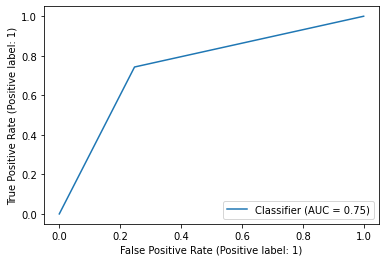

In [13]:
# ROC plot
logreg_roc = RocCurveDisplay.from_predictions(labels['label'].values, logreg_preds[label_idx]>=0.5)

The higher the ROC, the better the model.
- Shows a trade-off between sensitivity and specificity.
    - Sensitivity is the ability to correctly identify a true case (true positives).
    - Specificity is the ability to correctly identify those who are not a true case (true negatives).

# LightGBM

In [14]:
# Initialize LabelEncoder
enc = LabelEncoder()

# Transform the predicted variables into categories
lgb_y_cat = enc.fit_transform(labels['label'].values)

In [15]:
# Create dataset
lgb_dataset = lightgbm.Dataset(train_array[label_idx], label=lgb_y_cat)

# Parameters
params = {'objective': 'binary', 'metric': ['auc', 'binary_logloss'], 'seed': 42}

# Cross validation of the model
cross_val_lgb = lightgbm.cv(params, lgb_dataset, 10, nfold=10, shuffle=True)

[LightGBM] [Info] Number of positive: 9000, number of negative: 9000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.342293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 884323
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 3498
[LightGBM] [Info] Number of positive: 9000, number of negative: 9000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.292049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 884323
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 3498
[LightGBM] [Info] Number of positive: 9000, number of negative: 9000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.309130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 884323


In [16]:
# See the cross-validation estimator details
for key,value in cross_val_lgb.items():
    print(f"{key}: {value}")

auc-mean: [0.79593075, 0.8017174499999999, 0.8034461, 0.8051752500000001, 0.8056094, 0.80607565, 0.8066434000000001, 0.8071314, 0.8073050499999999, 0.8073460499999999]
auc-stdv: [0.007689240808590927, 0.008386323394223483, 0.008646718376933527, 0.00854591568894172, 0.008679662521665233, 0.009083111526481448, 0.008833665999459105, 0.008624589378051556, 0.008750293853494278, 0.00897456223291699]
binary_logloss-mean: [0.665914472761586, 0.6438110579956484, 0.6256736256978517, 0.6102932424041689, 0.5976358103956583, 0.5868556275980363, 0.5778072267945302, 0.570015473462355, 0.5634649676989264, 0.5580100324973001]
binary_logloss-stdv: [0.0007271609599974463, 0.001405301157969772, 0.0020605439735853982, 0.0025916087920025473, 0.0031284756987838645, 0.0036650230745286557, 0.004070073976263526, 0.0043681300171896495, 0.00480674507258566, 0.005226624092919829]


In [17]:
# Initialize LGBMClassifier
lgb_model = LGBMClassifier(boosting_type='gbdt', objective='binary', learning_rate=0.03, n_estimators=500, random_state=1, n_jobs=-1, metric=['auc', 'binary_logloss'], silent=False)

The fit function takes an array-like or sparse matrix of shape = [n_samples, n_features]. So, this will need to be checked before going further.

In [18]:
# Training matrix
train_array[label_idx].shape

(20000, 3500)

In [19]:
# Get the predictions
lgb_model.fit(train_array[label_idx], labels['label'].values, eval_metric='binary_logloss')

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 884323
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 3498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.03, metric=['auc', 'binary_logloss'],
               n_estimators=500, objective='binary', random_state=1,
               silent=False)

The predict function takes an array-like or sparse matrix of shape [n_samples, n_features]. 

In [20]:
# Get the prediction probabilities
lgb_preds_final = lgb_model.predict_proba(train_array)[:,-1]

In [21]:
# Calculate the log loss
lgb_log_loss = log_loss(labels, lgb_preds_final[label_idx])

# View
print(f"The log loss score of the LightGBM model is {lgb_log_loss}.")

The log loss score of the LightGBM model is 0.3055506514357098.
